## 0. Importar librerias



In [1]:
import osmnx
import math
import myst_nb
import osmnx as ox
import networkx as nx


# 1. Obtener información de capa vial

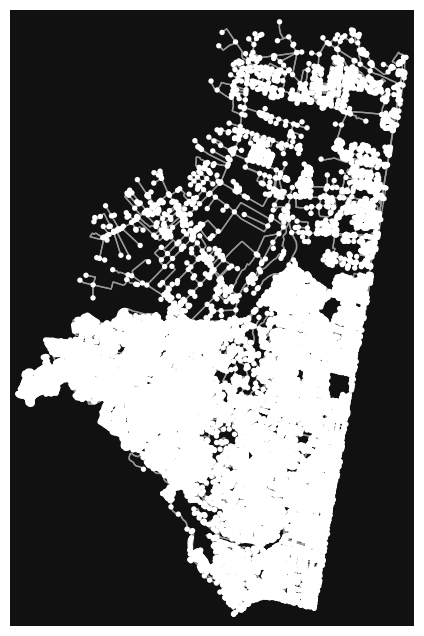

In [2]:
PLACE_NAME = "Suba, Bogotá, Colombia"
graph = ox.graph_from_place(
    PLACE_NAME,
    network_type="drive"
)

# Get the area of interest polygon
place_polygon = ox.geocode_to_gdf(PLACE_NAME)

# Re-project the polygon to a local projected CRS (so that the CRS unit is meters)
place_polygon = place_polygon.to_crs("EPSG:3067")

# Buffer by 200 meters
place_polygon["geometry"] = place_polygon.buffer(200)

# Re-project the polygon back to WGS84 (required by OSMnx)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph = ox.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="all"
)

fig, ax = ox.plot_graph(graph)


In [3]:
# Retrieve only edges from the graph
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)
edges.head()

osmid  highway  oneway reversed      length  \
u         v           key                                                     
255476400 4913735031  0     645873850  footway   False    False    8.146538   
          381991485   0    1195009265  primary    True    False   11.921676   
          11774394549 0     645873850  footway   False     True   12.706621   
259665451 5718775594  0     809284675    trunk    True    False  745.334231   
          273536445   0    1153629523    trunk    True    False  110.133567   

                          lanes                name  \
u         v           key                             
255476400 4913735031  0     NaN                 NaN   
          381991485   0       3      Transversal 60   
          11774394549 0     NaN                 NaN   
259665451 5718775594  0       3  Avenida Carrera 45   
          273536445   0       2  Avenida Carrera 45   

                                                                    geometry  \
u         v           key                                                      
255476400 4913735031  0    LINESTRING (-74.07226 4.71122, -74.07219 4.71124)   
          381991485   0    LINESTRING (-74.07226 4.71122, -74.07224 4.71112)   
          11774394549 0    LINESTRING (-74.07226 4.71122, -74.07231 4.711...   
259665451 5718775594  0    LINESTRING (-74.04663 4.75285, -74.04657 4.752...   
          273536445   0    LINESTRING (-74.04663 4.75285, -74.04663 4.752...   

                          maxspeed  ref service access bridge junction width  \
u         v           key                                                      
255476400 4913735031  0        NaN  NaN     NaN    NaN    NaN      NaN   NaN   
          381991485   0        NaN  NaN     NaN    NaN    NaN      NaN   NaN   
          11774394549 0        NaN  NaN     NaN    NaN    NaN      NaN   NaN   
259665451 5718775594  0         50  NaN     NaN    NaN    NaN      NaN   NaN   
          273536445   0         60  NaN     NaN    NaN    NaN      NaN   NaN   

                          area tunnel  
u         v           key              
255476400 4913735031  0    NaN    NaN  
          381991485   0    NaN    NaN  
          11774394549 0    NaN    NaN  
259665451 5718775594  0    NaN    NaN  
          273536445   0    NaN    NaN

In [4]:
edges["highway"].value_counts()

highway
residential                         20584
footway                             19040
service                             14758
tertiary                             3934
cycleway                             2376
secondary                            1483
primary                              1048
[footway, residential]                566
trunk                                 446
path                                  344
[footway, service]                    178
unclassified                          156
primary_link                          149
corridor                              124
trunk_link                            117
[footway, corridor]                    94
pedestrian                             93
steps                                  84
[footway, steps]                       80
[residential, service]                 70
track                                  48
[steps, residential]                   18
secondary_link                         15
[service, path]           

In [5]:
# Transform the graph to UTM
graph = ox.project_graph(graph) 

# Extract reprojected nodes and edges
nodes, edges = ox.graph_to_gdfs(graph)

nodes.crs

<Projected CRS: EPSG:32618>
Name: WGS 84 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 78°W and 72°W, northern hemisphere between equator and 84°N, onshore and offshore. Bahamas. Canada - Nunavut; Ontario; Quebec. Colombia. Cuba. Ecuador. Greenland. Haiti. Jamaica. Panama. Turks and Caicos Islands. United States (USA). Venezuela.
- bounds: (-78.0, 0.0, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

---


## 2. Analysing network properties

Now that we have prepared a routable network graph, we can turn to the more
analytical features of OSMnx, and extract information about the network.
To compute basic network characteristics, use
[`osmnx.basic_stats()`](https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.stats.basic_stats):

In [6]:
# Calculate network statistics
ox.basic_stats(graph)

{'n': 25254,
 'm': 65882,
 'k_avg': 5.217549695097806,
 'edge_length_total': 3468036.0851020496,
 'edge_length_avg': 52.640115435203086,
 'streets_per_node_avg': 2.8508751088936406,
 'streets_per_node_counts': {0: 0,
  1: 4659,
  2: 39,
  3: 15048,
  4: 5434,
  5: 65,
  6: 9},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1844856260394393,
  2: 0.0015443098123069613,
  3: 0.5958660014255167,
  4: 0.21517383384810326,
  5: 0.0025738496871782687,
  6: 0.0003563791874554526},
 'intersection_count': 20595,
 'street_length_total': 1915497.063372356,
 'street_segment_count': 35925,
 'street_length_avg': 53.31933370556314,
 'circuity_avg': 1.064273695343658,
 'self_loop_proportion': 0.003312456506610995}

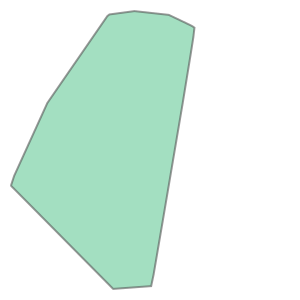

In [7]:
convex_hull = edges.geometry.union_all().convex_hull
convex_hull

In [8]:
stats = ox.basic_stats(graph, area=convex_hull.area)
stats

{'n': 25254,
 'm': 65882,
 'k_avg': 5.217549695097806,
 'edge_length_total': 3468036.0851020496,
 'edge_length_avg': 52.640115435203086,
 'streets_per_node_avg': 2.8508751088936406,
 'streets_per_node_counts': {0: 0,
  1: 4659,
  2: 39,
  3: 15048,
  4: 5434,
  5: 65,
  6: 9},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.1844856260394393,
  2: 0.0015443098123069613,
  3: 0.5958660014255167,
  4: 0.21517383384810326,
  5: 0.0025738496871782687,
  6: 0.0003563791874554526},
 'intersection_count': 20595,
 'street_length_total': 1915497.063372356,
 'street_segment_count': 35925,
 'street_length_avg': 53.31933370556314,
 'circuity_avg': 1.064273695343658,
 'self_loop_proportion': 0.003312456506610995,
 'node_density_km': 227.96386175104135,
 'intersection_density_km': 185.9078060015323,
 'edge_density_km': 31305.41295049601,
 'street_density_km': 17290.888878559494}

In [9]:
myst_nb.glue("node_density_km", round(stats["node_density_km"], 1))
myst_nb.glue("edge_length_total", math.floor(stats["edge_length_total"] / 1000))

228.0

3468

In [10]:
origin = (
    ox.geocode_to_gdf("Portal suba, bogota")  # fetch geolocation
    .to_crs(edges.crs)  # transform to UTM
    .at[0, "geometry"]  # pick geometry of first row
    .centroid  # use the centre point
)

destination = (
    ox.geocode_to_gdf("Clinica la colina, bogota")
    .to_crs(edges.crs)
    .at[0, "geometry"]
    .centroid
)

In [11]:
origin_node_id = ox.nearest_nodes(graph, origin.x, origin.y)
origin_node_id

12844382887

In [12]:
destination_node_id = ox.nearest_nodes(graph, destination.x, destination.y)
destination_node_id

9735691677

Comparar resultados de los algoritmos

(<Figure size 800x800 with 1 Axes>, <Axes: >)

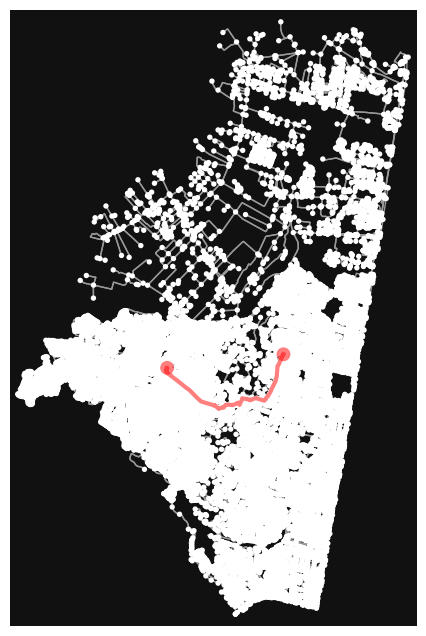

In [13]:
# Ruta con Dijkstra
route_dijkstra = nx.shortest_path(graph, origin_node_id, destination_node_id, weight="length", method="dijkstra")

# Graficar 
fig, ax = ox.plot_graph(graph, show=False, close=False)
ox.plot_graph_route(graph, route_dijkstra, route_color='red', ax=ax, route_linewidth=3, orig_dest_node_color='green', show=False, close=False)


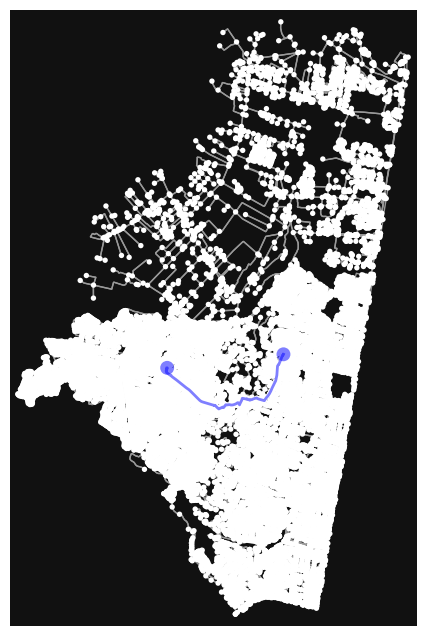

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [14]:
# Ruta con A*
route_astar = nx.astar_path(graph, origin_node_id, destination_node_id, weight="length")
# Graficar ambas rutas
fig, ax = ox.plot_graph(graph, show=False, close=False)
ox.plot_graph_route(graph, route_astar, route_color='blue', ax=ax, route_linewidth=2, orig_dest_node_color='orange', show=True, close=True)


In [15]:
diferentes = [x for x in route_dijkstra if x not in route_astar] + [x for x in route_astar if x not in route_dijkstra]
print(diferentes)  

[]


### Comparación de Resultados: Dijkstra vs A*

Una vez analizada la lista de resultados, se concluye que **no hay diferencias en las rutas calculadas** para esta red entre los algoritmos de Dijkstra y A*. Ambos producen el mismo camino óptimo.

No obstante, en términos computacionales, se observa una **ligera ventaja en el tiempo de ejecución del algoritmo A***, el cual fue aproximadamente un **6% más rápido** que Dijkstra en este caso específico.


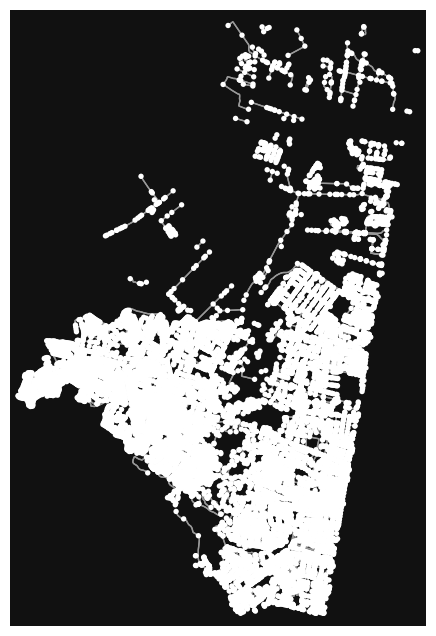

In [16]:
PLACE_NAME = "Suba, Bogotá, Colombia"
graph2 = ox.graph_from_place(
    PLACE_NAME,
    network_type="drive"
)

# Get the area of interest polygon
place_polygon = ox.geocode_to_gdf(PLACE_NAME)
place_polygon = place_polygon.to_crs("EPSG:3067")
place_polygon["geometry"] = place_polygon.buffer(200)
place_polygon = place_polygon.to_crs("EPSG:4326")

# Retrieve the network graph
graph2 = ox.graph_from_polygon(
    place_polygon.at[0, "geometry"],
    network_type="all"
)

# Convert graph edges to GeoDataFrame
edges = ox.graph_to_gdfs(graph, nodes=False, edges=True)


edges_selected = edges[edges['highway'].isin(['residential', 'footway'])]

# Crear subgrafo solo con esos edges
edges_selected = nx.edge_subgraph(graph, edges_selected.index).copy()

# Graficar solo las vías 'primary'
fig, ax = ox.plot_graph(edges_selected)

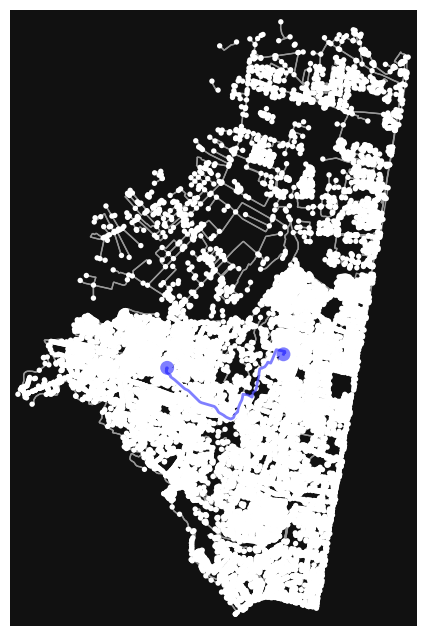

In [17]:
# Filtrar solo edges donde highway sea 'primary', 'secondary' o 'residential'
edges_selected = edges[~edges['highway'].isin(['secondary', 'residential'])]

# Crear subgrafo solo con esos edges
graph_selected = nx.edge_subgraph(graph, edges_selected.index).copy()

# Obtener nodos del subgrafo
nodes_selected = list(graph_selected.nodes)

# Buscar el nodo más cercano en el subgrafo filtrado
origin_node_id = ox.nearest_nodes(graph_selected, origin.x, origin.y)
destination_node_id = ox.nearest_nodes(graph_selected, destination.x, destination.y)

# Verificar si ambos nodos están en el mismo componente conexo
if nx.has_path(graph_selected, origin_node_id, destination_node_id):
    # Calcular la ruta en el subgrafo filtrado
    route_dijkstra2 = nx.shortest_path(graph_selected, origin_node_id, destination_node_id, weight="length", method="dijkstra")
    # Graficar la ruta sobre el subgrafo filtrado
    fig, ax = ox.plot_graph(graph_selected, show=False, close=False)
    ox.plot_graph_route(graph_selected, route_dijkstra2, route_color='blue', ax=ax, route_linewidth=2, orig_dest_node_color='orange', show=True, close=True)
else:
    print("No existe un camino entre origen y destino en el subgrafo filtrado.")

In [22]:
route_nodes = nodes.loc[route_dijkstra2]
route_nodes

,y,x,highway,street_count,geometry
osmid,,,,,
12844382887,524737.349094,600417.771867,NaN,3,POINT (600417.772 524737.349)
12844382885,524719.868443,600424.349499,NaN,4,POINT (600424.349 524719.868)
9851261791,524712.466983,600394.735165,NaN,3,POINT (600394.735 524712.467)
12844382876,524693.734141,600399.051869,NaN,3,POINT (600399.052 524693.734)
9851261793,524660.135954,600389.391182,NaN,3,POINT (600389.391 524660.136)
...,...,...,...,...,...
9735691691,525151.051935,603665.253100,NaN,3,POINT (603665.253 525151.052)
9735691693,525148.982801,603647.554641,NaN,3,POINT (603647.555 525148.983)
9735691687,525150.555757,603641.674280,NaN,3,POINT (603641.674 525150.556)


In [25]:
import shapely.geometry

# Obtener las geometrías de los nodos de la ruta
route_nodes = nodes.loc[route_dijkstra2]
route_line = shapely.geometry.LineString(route_nodes.geometry.values)

In [26]:
import geopandas

route_geom = geopandas.GeoDataFrame(
    {
        "geometry": [route_line],
        "osm_nodes": [route_dijkstra2],
    },
    crs=edges.crs
)

# Calculate the route length
route_geom["length_m"] = route_geom.length

route_geom.head()

,geometry,osm_nodes,length_m
0,"LINESTRING (600417.772 524737.349, 600424.349 ...","[12844382887, 12844382885, 9851261791, 1284438...",5400.677611


In [27]:
buildings = osmnx.features_from_place(
    PLACE_NAME,
    {
        "building" : True
    }
).to_crs(edges.crs)

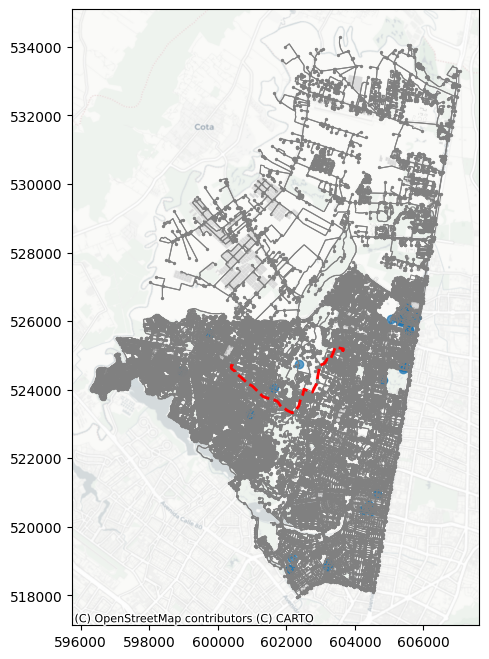

In [28]:
import contextily
import matplotlib.pyplot

fig, ax = matplotlib.pyplot.subplots(figsize=(12,8))

# Plot edges and nodes
edges.plot(ax=ax, linewidth=0.75, color='gray')
nodes.plot(ax=ax, markersize=2, color='gray')

# Add buildings
ax = buildings.plot(ax=ax, facecolor='lightgray', alpha=0.7)

# Add the route
ax = route_geom.plot(ax=ax, linewidth=2, linestyle='--', color='red')

# Add basemap
contextily.add_basemap(ax, crs=buildings.crs, source=contextily.providers.CartoDB.Positron)

In [29]:
edges.head()

osmid  highway  oneway reversed     length  \
u          v           key                                                    
255476400  4913735031  0     645873850  footway   False    False   8.146538   
           381991485   0    1195009265  primary    True    False  11.921676   
           11774394549 0     645873850  footway   False     True  12.706621   
4913735031 4069368783  0     584488049  service    True    False  12.431178   
           255476400   0     645873850  footway   False     True   8.146538   

                           lanes            name  \
u          v           key                         
255476400  4913735031  0     NaN             NaN   
           381991485   0       3  Transversal 60   
           11774394549 0     NaN             NaN   
4913735031 4069368783  0     NaN    TransMilenio   
           255476400   0     NaN             NaN   

                                                                     geometry  \
u          v           key                                                      
255476400  4913735031  0    LINESTRING (602891.74 520811.6, 602899.679 520...   
           381991485   0    LINESTRING (602891.74 520811.6, 602894.273 520...   
           11774394549 0    LINESTRING (602891.74 520811.6, 602886.484 520...   
4913735031 4069368783  0    LINESTRING (602899.679 520813.446, 602902.257 ...   
           255476400   0    LINESTRING (602899.679 520813.446, 602891.74 5...   

                           access maxspeed  ref service bridge junction width  \
u          v           key                                                      
255476400  4913735031  0      NaN      NaN  NaN     NaN    NaN      NaN   NaN   
           381991485   0      NaN      NaN  NaN     NaN    NaN      NaN   NaN   
           11774394549 0      NaN      NaN  NaN     NaN    NaN      NaN   NaN   
4913735031 4069368783  0       no      NaN  NaN     NaN    NaN      NaN   NaN   
           255476400   0      NaN      NaN  NaN     NaN    NaN      NaN   NaN   

                           area tunnel  
u          v           key              
255476400  4913735031  0    NaN    NaN  
           381991485   0    NaN    NaN  
           11774394549 0    NaN    NaN  
4913735031 4069368783  0    NaN    NaN  
           255476400   0    NaN    NaN

In [ ]:
# 1. Crear un buffer de 50 m alrededor de la ruta
buffer_50m = route_geom.geometry.buffer(50).iloc[0]

# 2. Seleccionar edificios que intersectan el buffer
buildings_along_route = buildings[buildings.intersects(buffer_50m)]

# 3. Contar edificios totales y por tipo
total_buildings = buildings_along_route.shape[0]
buildings_by_tag = buildings_along_route['building'].value_counts()

print(f"Total de edificios en el corredor: {total_buildings}")
print("Conteo por tipo de edificio:")
print(buildings_by_tag)


Total de edificios en el corredor: 43
Conteo por tipo de edificio:
building
yes           33
roof           6
school         2
commercial     1
warehouse      1
Name: count, dtype: int64


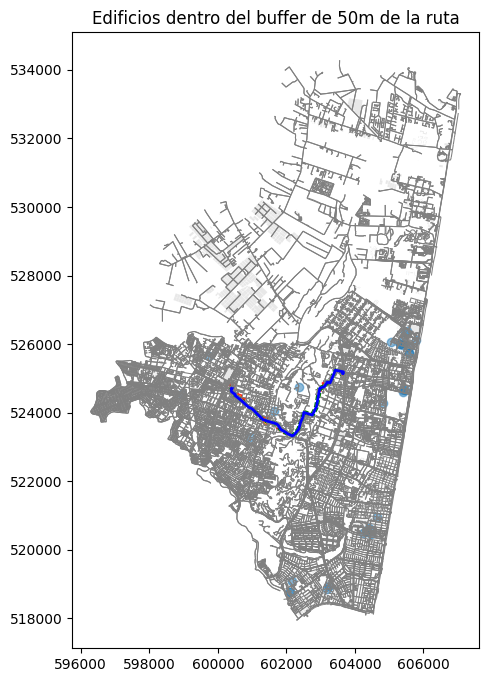

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
edges.plot(ax=ax, linewidth=0.75, color='gray')
buildings.plot(ax=ax, facecolor='lightgray', alpha=0.5)
buildings_along_route.plot(ax=ax, facecolor='orange', edgecolor='red', alpha=0.8)
route_geom.plot(ax=ax, linewidth=2, color='blue')
geopandas.GeoSeries(buffer_50m).plot(ax=ax, facecolor='none', edgecolor='green', linestyle='--')
plt.title("Edificios dentro del buffer de 50m de la ruta")
plt.show()

In [ ]:
# 4. Exportar a GeoJSON
buildings_along_route.to_file("buildings_along_route.geojson", driver="GeoJSON")